In [13]:
import numpy as np 
import pandas as pd 
import json # library to handle JSON files


from geopy.geocoders import Nominatim 

import requests
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans


import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### 1) We scrape the Wikipedia page using Beautiful Soup.

In [2]:
import urllib.request, urllib.parse,urllib.error
from bs4 import BeautifulSoup

req = requests.get("https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050")
soup = BeautifulSoup(req.content,'lxml')
table = soup.find_all('table')[0]
df_list = pd.read_html(str(table))
print(df_list)

[    Postcode           Borough          Neighbourhood
0        M1A      Not assigned           Not assigned
1        M2A      Not assigned           Not assigned
2        M3A        North York              Parkwoods
3        M4A        North York       Victoria Village
4        M5A  Downtown Toronto           Harbourfront
..       ...               ...                    ...
282      M8Z         Etobicoke              Mimico NW
283      M8Z         Etobicoke     The Queensway West
284      M8Z         Etobicoke  Royal York South West
285      M8Z         Etobicoke         South of Bloor
286      M9Z      Not assigned           Not assigned

[287 rows x 3 columns]]


### 2) Creating a dataframe containing all data & change the name of dataframe columns:

In [3]:
# Create a dataframe containing all data (using concat function):
df = pd.concat(df_list)

#After, we rename Postcode column:
df=df.rename(columns={"Postcode": "Postal Code","Neighbourhood": "Neighborhood"})

df.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### 3) We eliminate 'Not assigned' postal codes rows: 


In [19]:
df=df[df.Borough !='Not assigned'].reset_index()
df.head()

,index,Postal Code,Borough,Neighborhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,Harbourfront
3,5,M6A,North York,Lawrence Heights
4,6,M6A,North York,Lawrence Manor


### 4) Grouping neighborhoods

In [20]:
#First, we apply groupby command in the data frame:
df2=df.groupby('Postal Code')['Neighborhood'].apply(lambda Neighborhood: ', '.join(Neighborhood)).reset_index()
df2.head()

,Postal Code,Neighborhood
0,M1B,"Rouge, Malvern"
1,M1C,"Highland Creek, Rouge Hill, Port Union"
2,M1E,"Guildwood, Morningside, West Hill"
3,M1G,Woburn
4,M1H,Cedarbrae


In [23]:
#We incorporate the borough column to the dataframe:

boroughs=[]
for i in range(0,len(df2)):
    for j in range(0,len(df)):
        if df2.loc[i,'Postal Code']==df.loc[j,'Postal Code']:
            boroughs.append(df.loc[j,'Borough'])
            break
        else:
            continue

df2['Borough'] = boroughs

#Finally, we sort the columns:
df2 = df2[['Postal Code','Borough','Neighborhood']]
df2.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [24]:
df2.shape

(103, 3)

### 5) We obtain postal codes coordinates from csv file:

In [25]:
df_coordinates=pd.read_csv('Geospatial_Coordinates.csv')
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 6) Coordinates dataframe:

In [26]:
#Using merge command we can add longitude and latitude coordinates for each postal code:

toronto_data=df2.merge(df_coordinates,how='inner',left_on='Postal Code', right_on='Postal Code',validate='1:1') 

toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [27]:
toronto_data.shape

(103, 5)

### 7) Maps preparation:

In [32]:
#First we define the basic coordinates for map location:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [33]:
#Basic map definition (postal codes location):

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# Map markers
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 8) Downloading data from Foursquare API. We're interested in basic venue information:

In [2]:
#Foursquare credentials:
with open(r'foursquarecredentials.json') as cred:
    credentials=json.load(cred)
CLIENT_ID=credentials['CLIENT_ID']
CLIENT_SECRET=credentials['CLIENT_SECRET']
VERSION=credentials['VERSION']
LIMIT=credentials['LIMIT']


In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [50]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Rouge, Malvern
Highland Creek, Rouge Hill, Port Union
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park, Ionview, Kennedy Park
Clairlea, Golden Mile, Oakridge
Cliffcrest, Cliffside, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Scarborough Town Centre, Wexford Heights
Maryvale, Wexford
Agincourt
Clarks Corners, Sullivan, Tam O'Shanter
Agincourt North, L'Amoreaux East, Milliken, Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
Silver Hills, York Mills
Newtonbrook, Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park, Don Mills South
Bathurst Manor, Downsview North, Wilson Heights
Northwood Park, York University
CFB Toronto, Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens, Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, 

In [51]:
print(toronto_venues.shape)
toronto_venues.head()

(2250, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [67]:
toronto_venues.describe(include='all')

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
count,2250,2250.000000,2250.000000,2250,2250.000000,2250.000000,2250
unique,99,NaN,NaN,1453,NaN,NaN,275
top,St. James Town,NaN,NaN,Starbucks,NaN,NaN,Coffee Shop
freq,100,NaN,NaN,71,NaN,NaN,191
mean,NaN,43.673339,-79.388260,NaN,43.673439,-79.388242,NaN
std,NaN,0.041106,0.052695,NaN,0.040941,0.052776,NaN
min,NaN,43.602414,-79.615819,NaN,43.599152,-79.621765,NaN
25%,NaN,43.648198,-79.400049,NaN,43.648737,-79.399955,NaN
50%,NaN,43.657162,-79.381752,NaN,43.655721,-79.381681,NaN
75%,NaN,43.679557,-79.374846,NaN,43.678303,-79.372464,NaN


### 8) Preparing dataframe to cluster analysis.

In [59]:
# First, we have to transform categorical data to one hot encoding:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]


toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
#Group data by Neighborhood:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00


In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [110]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], 
                                                                          num_top_venues)


neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Thai Restaurant,Café,Bar,Steakhouse,Concert Hall,Bookstore,Seafood Restaurant,Breakfast Spot
1,Agincourt,Latin American Restaurant,Clothing Store,Lounge,Breakfast Spot,Skating Rink,Eastern European Restaurant,Electronics Store,Dumpling Restaurant,Drugstore,Department Store
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Discount Store,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Pizza Place,Pharmacy,Donut Shop
4,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Skating Rink,Gym,Pub,Pharmacy,Pool,Sandwich Place,Dim Sum Restaurant,Deli / Bodega


### 9) Clustering analysis

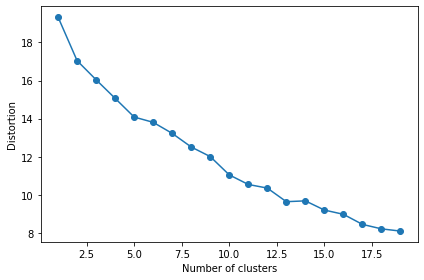

In [127]:
#Using the elbow method to find the optimal number of clusters
import matplotlib.pyplot as plt

distortions = []
for i in range(1, 20):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(toronto_grouped_clustering)
    distortions.append(km.inertia_)
plt.plot(range(1, 20), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('images/11_03.png', dpi=300)
plt.show()

##### Elbow analysis conclusion: the graph doesn't let us to get a valid  clusters number. Alternatively, we've tried with k values (from 3 to 10) and in all cases we can identify two clear and well differentiated clusters (we've attached results for kclusters=3):

In [111]:
# set number of clusters ()
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood',1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, init='k-means++',random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100]
#len(kmeans.labels_)


array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1])

In [112]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,"Adelaide, King, Richmond",Coffee Shop,Restaurant,Thai Restaurant,Café,Bar,Steakhouse,Concert Hall,Bookstore,Seafood Restaurant,Breakfast Spot
1,0,Agincourt,Latin American Restaurant,Clothing Store,Lounge,Breakfast Spot,Skating Rink,Eastern European Restaurant,Electronics Store,Dumpling Restaurant,Drugstore,Department Store
2,1,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
3,0,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Beer Store,Fried Chicken Joint,Discount Store,Sandwich Place,Fast Food Restaurant,Japanese Restaurant,Pizza Place,Pharmacy,Donut Shop
4,0,"Alderwood, Long Branch",Pizza Place,Coffee Shop,Skating Rink,Gym,Pub,Pharmacy,Pool,Sandwich Place,Dim Sum Restaurant,Deli / Bodega


### 10) Analyzing clustering results:

In [113]:
toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged=toronto_merged.dropna()
toronto_merged.head() 

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,0.0,Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,0.0,Bar,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Department Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,0.0,Rental Car Location,Mexican Restaurant,Spa,Breakfast Spot,Intersection,Bank,Medical Center,Electronics Store,Cosmetics Shop,Construction & Landscaping
3,M1G,Scarborough,Woburn,43.770992,-79.216917,0.0,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,0.0,Gas Station,Caribbean Restaurant,Fried Chicken Joint,Bank,Athletics & Sports,Thai Restaurant,Bakery,Hakka Restaurant,Drugstore,Donut Shop


In [125]:
# create cluster map

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], 
    toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    cluster=int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### Now, we are going to analyze each cluster:

In [115]:
cluster0=toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, 
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster0.head()

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,0.0,Fast Food Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
1,Scarborough,0.0,Bar,Women's Store,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Department Store
2,Scarborough,0.0,Rental Car Location,Mexican Restaurant,Spa,Breakfast Spot,Intersection,Bank,Medical Center,Electronics Store,Cosmetics Shop,Construction & Landscaping
3,Scarborough,0.0,Coffee Shop,Korean Restaurant,Women's Store,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
4,Scarborough,0.0,Gas Station,Caribbean Restaurant,Fried Chicken Joint,Bank,Athletics & Sports,Thai Restaurant,Bakery,Hakka Restaurant,Drugstore,Donut Shop


In [116]:
cluster0.describe(include='all')

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,88,88.0,88,88,88,88,88,88,88,88,88,88
unique,10,NaN,46,49,52,51,54,53,54,50,48,47
top,North York,NaN,Coffee Shop,Coffee Shop,Café,Bank,Italian Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
freq,19,NaN,20,11,6,5,6,7,9,8,10,6
mean,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Cluster 0: coffee shops & cafes are the most frequent venue following by other services (banks and restaurants)

In [122]:
cluster1=toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, 
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
cluster1.head(10)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,1.0,Park,Playground,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
23,North York,1.0,Park,Bank,Convenience Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega
25,North York,1.0,Park,Food & Drink Shop,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Ethiopian Restaurant
30,North York,1.0,Other Repair Shop,Airport,Park,College Stadium,College Rec Center,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore
40,East York,1.0,Park,Intersection,Convenience Store,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Deli / Bodega
44,Central Toronto,1.0,Park,Bus Line,Swim School,Ethiopian Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run
50,Downtown Toronto,1.0,Park,Playground,Trail,Distribution Center,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
74,York,1.0,Park,Market,Women's Store,Gluten-free Restaurant,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Golf Course
90,Etobicoke,1.0,Park,River,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Deli / Bodega,Dog Run
98,York,1.0,Park,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,College Gym


In [118]:
cluster1.describe(include='all')

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,10,10.0,10,10,10,10,10,10,10,10,10,10
unique,7,NaN,2,9,9,7,6,6,6,6,7,8
top,North York,NaN,Park,Playground,Convenience Store,Electronics Store,Eastern European Restaurant,Dim Sum Restaurant,Drugstore,Discount Store,Doner Restaurant,Dog Run
freq,3,NaN,9,2,2,3,3,3,3,3,3,2
mean,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Cluster 1: parks & playgrounds are the most frequent venue following by basic services (stores, etc.)

##### The following cluster are not enough relevant for the analysis:

In [123]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, 
                     toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,North York,2.0,Cafeteria,Dog Run,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Women's Store,Deli / Bodega
